In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import humanize

In [2]:
df = pd.read_csv('/work/compressed_data.csv.gz')

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [5]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [6]:
# Fix negative prices by converting to positive
df['UnitPrice'] = df['UnitPrice'].abs()

In [7]:
df['TransactionType'] = df['Quantity'].apply(lambda x: 'Return' if x<0 else 'Purchase')


In [8]:
df['Revenue'] = df['Quantity'] * df['UnitPrice']

In [9]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [10]:
# Sales including returns (for net revenue)
net_sales_df = df.copy()  # Keeps everything

# Sales excluding returns (pure purchases)
purchases_df = df[df['Quantity'] > 0].copy()

# Returns only
returns_df = df[df['Quantity'] < 0].copy()


In [11]:
net_sales_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TransactionType,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,Purchase,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Purchase,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,Purchase,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Purchase,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Purchase,20.34


In [12]:
#What is the number of purchases?
No_purchases = net_sales_df['InvoiceNo'].nunique()
print(f"Number Of Purchases: {No_purchases} transactions")


Number Of Purchases: 25900 transactions


In [13]:
# What is total revenue ?
total_revenue = net_sales_df['Revenue'].sum()
print("Total Sales : ",humanize.intword(total_revenue))

Total Sales :  9.8 million


In [14]:
# What is total quantity
total_quantity = net_sales_df['Quantity'].sum()
print("Total Quantity : ",humanize.intword(total_quantity))

Total Quantity :  5.2 million


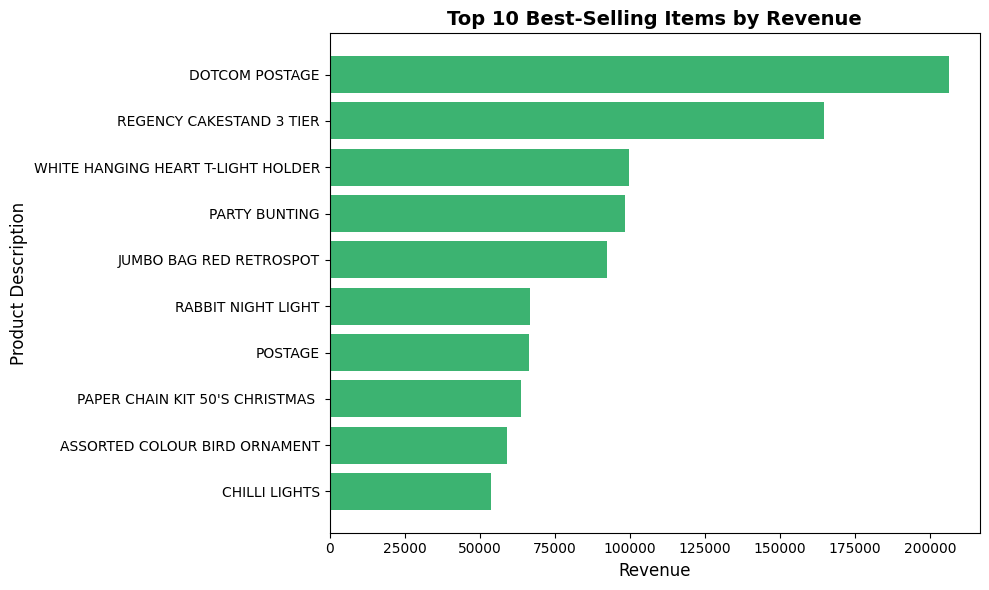

In [15]:
sales_by_item = net_sales_df.groupby('Description')['Revenue'].sum().reset_index().sort_values(by='Revenue',ascending=False).head(10)
plt.figure(figsize=(10,6))
plt.barh(
    y=sales_by_item['Description'],
    width=sales_by_item['Revenue'],
    color='mediumseagreen'
)

plt.title("Top 10 Best-Selling Items by Revenue", fontsize=14, fontweight='bold')
plt.xlabel("Revenue", fontsize=12)
plt.ylabel("Product Description", fontsize=12)
plt.gca().invert_yaxis()  # عشان المنتج الأعلى يظهر في الأعلى
plt.tight_layout()
plt.show()

In [16]:
# Who cusomers most buy ?
sales_by_customer = (
    net_sales_df
      .groupby('CustomerID')
      .agg({
          'Revenue':'sum',
          'InvoiceNo':'nunique'
      })
      .reset_index()
      .rename(columns={'Revenue':'TotalRevenue','InvoiceNo':'NumPurchases'})
      .sort_values(by=['TotalRevenue','NumPurchases'], ascending=[False,False])
      .head(10)
)

sales_by_customer


,CustomerID,TotalRevenue,NumPurchases
1703,14646.0,279489.02,77
4233,18102.0,256438.49,62
3758,17450.0,187482.17,55
1895,14911.0,132572.62,248
55,12415.0,123725.45,26
1345,14156.0,113384.14,66
3801,17511.0,88125.38,46
3202,16684.0,65892.08,31
1005,13694.0,62653.10,60
2192,15311.0,59419.34,118


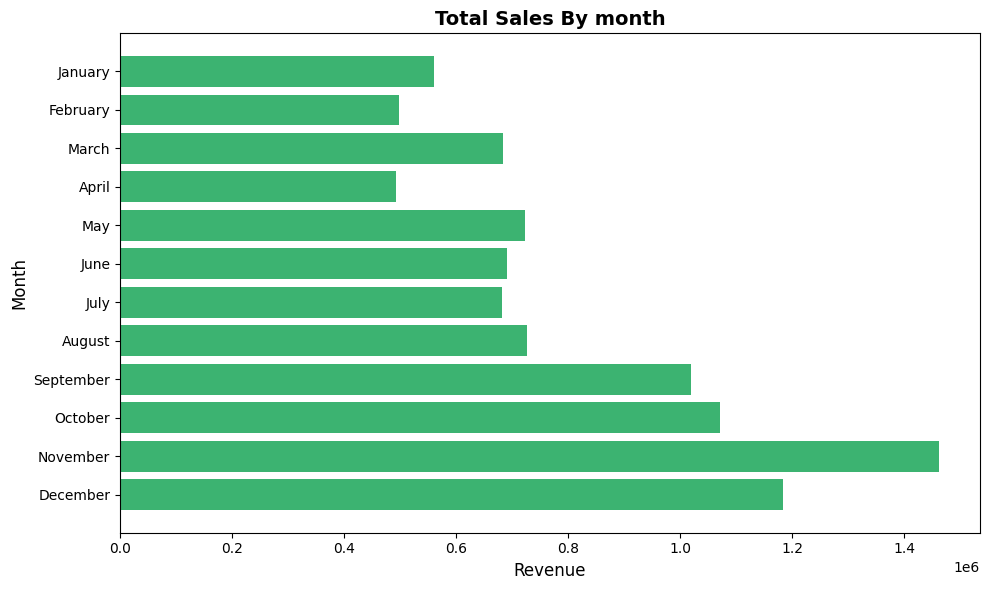

In [17]:
# what is total sales in months ?
net_sales_df['Month'] = net_sales_df['InvoiceDate'].dt.month_name()
net_sales_df['MonthNumber'] = net_sales_df['InvoiceDate'].dt.month
sales_by_month = (
    net_sales_df
    .groupby(['MonthNumber','Month'])['Revenue']
    .sum()
    .reset_index()
    .sort_values('MonthNumber')
)

plt.figure(figsize=(10,6))
plt.barh(
    y=sales_by_month['Month'],
    width=sales_by_month['Revenue'],
    color='mediumseagreen'
)

plt.title("Total Sales By month", fontsize=14, fontweight='bold')
plt.xlabel("Revenue", fontsize=12)
plt.ylabel("Month", fontsize=12)
plt.gca().invert_yaxis()  # عشان المنتج الأعلى يظهر في الأعلى
plt.tight_layout()
plt.show()

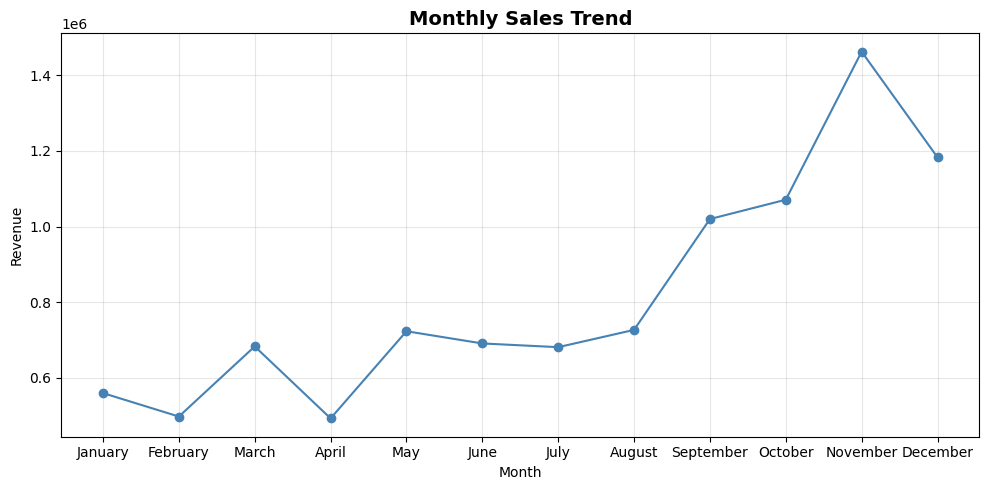

In [18]:
plt.figure(figsize=(10,5))
plt.plot(sales_by_month['Month'], sales_by_month['Revenue'], marker='o', color='steelblue')
plt.title("Monthly Sales Trend", fontsize=14, fontweight='bold')
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [19]:
sales_return_by_month = (
    net_sales_df
    .groupby(['MonthNumber','Month','TransactionType'])['Revenue']
    .sum()
    .unstack(fill_value=0)
    .reset_index()
)
sales_return_by_month['NetRevenue'] = sales_return_by_month['Purchase'] + sales_return_by_month['Return']
sales_return_by_month

TransactionType,MonthNumber,Month,Purchase,Return,NetRevenue
0,1,January,691364.560,-131364.30,560000.260
1,2,February,523631.890,-25569.24,498062.650
2,3,March,717639.360,-34372.28,683267.080
3,4,April,537808.621,-44601.50,493207.121
4,5,May,770536.020,-47202.51,723333.510
5,6,June,761739.900,-70616.78,691123.120
6,7,July,719221.191,-37921.08,681300.111
7,8,August,781262.500,-54333.75,726928.750
8,9,September,1058590.172,-38902.55,1019687.622
9,10,October,1154979.300,-84274.63,1070704.670


In [20]:
monthly_kpi = (
    net_sales_df
    .groupby(['MonthNumber','Month','TransactionType'])
    .agg(
        Revenue = ('Revenue','sum'),
        Transactions = ('InvoiceNo','nunique'),
        Quantity=('Quantity','sum')
    )
    .reset_index()
)
monthly_kpi['AOV'] = monthly_kpi['Revenue'] / monthly_kpi['Transactions']

monthly_kpi

,MonthNumber,Month,TransactionType,Revenue,Transactions,Quantity,AOV
0,1,January,Purchase,691364.560,1120,397716,617.289786
1,1,January,Return,-131364.300,356,-88750,-369.000843
2,2,February,Purchase,523631.890,1126,286695,465.037202
3,2,February,Return,-25569.240,267,-8706,-95.764944
4,3,March,Purchase,717639.360,1531,384950,468.738968
5,3,March,Return,-34372.280,452,-33078,-76.044867
6,4,April,Purchase,537808.621,1318,312176,408.049030
7,4,April,Return,-44601.500,426,-23078,-104.698357
8,5,May,Purchase,770536.020,1731,399425,445.139237
9,5,May,Return,-47202.510,431,-19034,-109.518585


In [21]:
monthly_kpi['Revenue'] = monthly_kpi['Revenue'].apply(humanize.intword)
monthly_kpi['Quantity'] = monthly_kpi['Quantity'].apply(humanize.intword)
monthly_kpi['Transactions'] = monthly_kpi['Transactions'].apply(humanize.intword)

monthly_kpi[['Month','Revenue','Transactions','Quantity','AOV']]
monthly_kpi

,MonthNumber,Month,TransactionType,Revenue,Transactions,Quantity,AOV
0,1,January,Purchase,691.4 thousand,1.1 thousand,397.7 thousand,617.289786
1,1,January,Return,-131.4 thousand,356,-88.8 thousand,-369.000843
2,2,February,Purchase,523.6 thousand,1.1 thousand,286.7 thousand,465.037202
3,2,February,Return,-25.6 thousand,267,-8.7 thousand,-95.764944
4,3,March,Purchase,717.6 thousand,1.5 thousand,384.9 thousand,468.738968
5,3,March,Return,-34.4 thousand,452,-33.1 thousand,-76.044867
6,4,April,Purchase,537.8 thousand,1.3 thousand,312.2 thousand,408.049030
7,4,April,Return,-44.6 thousand,426,-23.1 thousand,-104.698357
8,5,May,Purchase,770.5 thousand,1.7 thousand,399.4 thousand,445.139237
9,5,May,Return,-47.2 thousand,431,-19.0 thousand,-109.518585


In [46]:
from rfm import RFM
r = RFM(
    net_sales_df,
    customer_id='CustomerID',
    transaction_date='InvoiceDate',
    amount='Revenue'
)
r.rfm_table


,CustomerID,recency,frequency,monetary_value,r,f,m,rfm_score,segment
0,15039,9,1483,19637.76,5,5,5,555,Champions
1,17735,1,690,13109.06,5,5,5,555,Champions
2,16549,9,925,4033.58,5,5,5,555,Champions
3,15218,10,166,5756.81,5,5,5,555,Champions
4,13767,1,399,16942.31,5,5,5,555,Champions
...,...,...,...,...,...,...,...,...,...
4367,17517,308,11,153.90,1,1,1,111,Lost
4368,12943,300,1,-3.75,1,1,1,111,Lost
4369,14705,198,1,179.00,1,1,1,111,Lost
4370,14699,213,8,109.13,1,1,1,111,Lost


In [52]:
r.segment_table


,segment,no of customers
0,Champions,926
1,Loyal Accounts,812
2,Low Spenders,399
3,Potential Loyalist,312
4,Promising,104
5,New Active Accounts,48
6,Need Attention,53
7,About to Sleep,397
8,At Risk,592
9,Lost,729


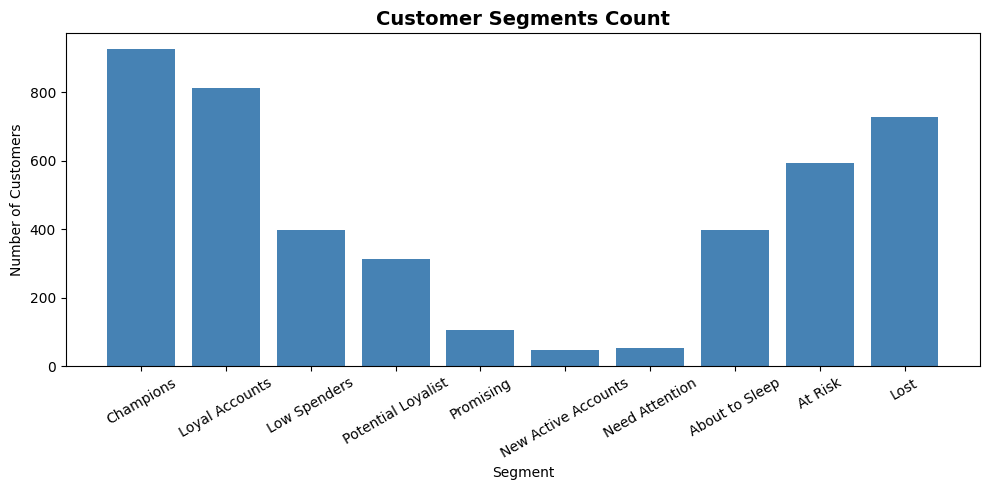

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.bar(r.segment_table['segment'], r.segment_table['no of customers'], color='steelblue')
plt.title('Customer Segments Count', fontsize=14, fontweight='bold')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


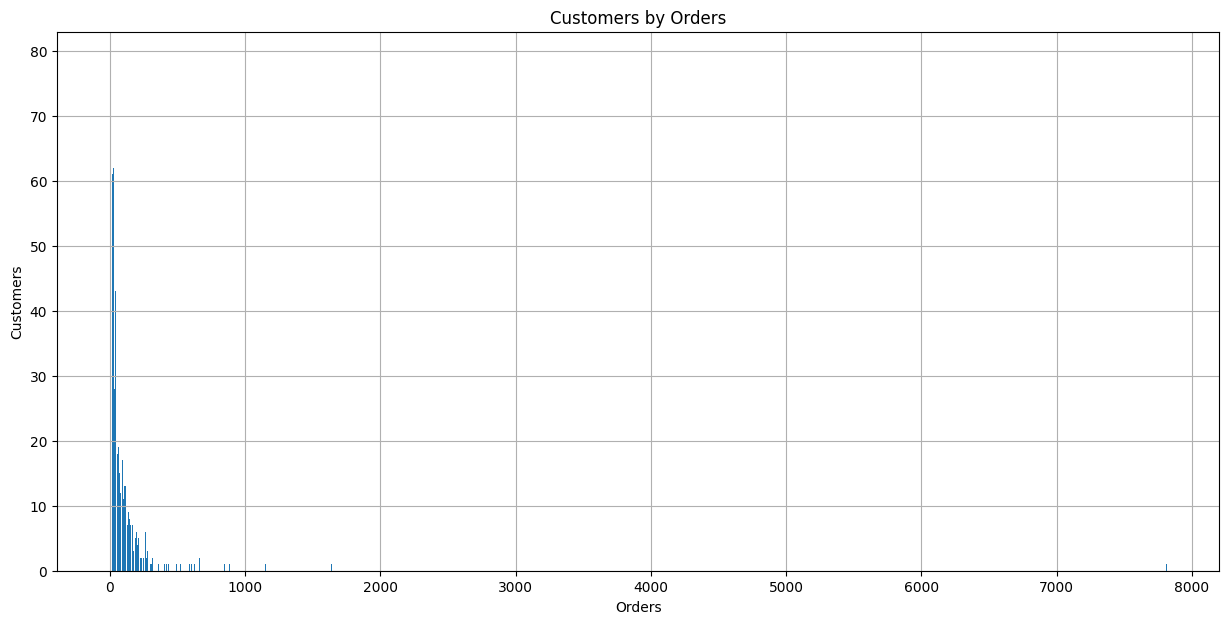

In [49]:
r.plot_rfm_order_distribution()

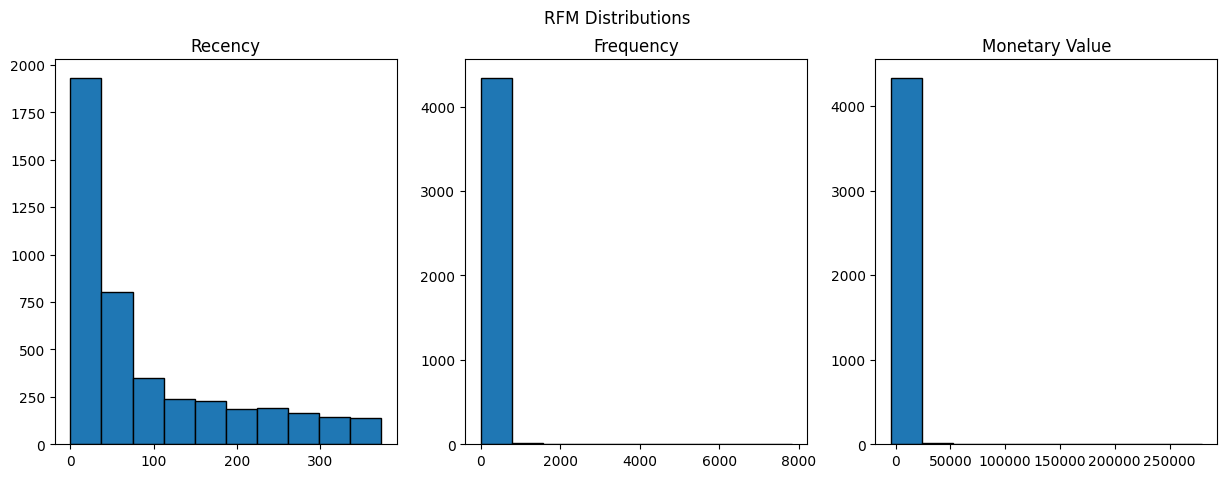

In [55]:
r.plot_rfm_histograms()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=518ea80f-8591-4503-a1b8-394fcba4e540' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>